In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# initialize params
seed = 152

num_iters = 25
T = 200  # time horizon
n = 5  # num historical samples
delta = 0.3
alpha = 0 # percentage of time to pull arm 0
mean_arms = [.5, .5-delta]  # note: arm 0 always better
n_arms = len(mean_arms)

RANDOM_REWARD = True
DEBUG = False
NON_DECREASING_UCB = True

In [3]:
np.random.seed(seed)
regret_data = []

def generate_dataset(n, alpha):
    """ generate historical samples """
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
        if RANDOM_REWARD: dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
        if not RANDOM_REWARD: dataset['0'].append(mean_arms[0])
    for _ in range(n - int(alpha*n)):
        if RANDOM_REWARD: dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
        if not RANDOM_REWARD: dataset['1'].append(mean_arms[1])
    return dataset

def conf_r(t, n_pulls):
    """ compute confidence radius """
    return np.sqrt(2*np.log(1+t) / n_pulls)
#     return np.sqrt(2*np.log(1+T) / n_pulls)
    

online_use_all_data_count = 0.0
online_data_use_percentage = []

algo_list = ['simple', 'online']
# algo_list = ['online']

# simple algorithm (Thorsten 2012)
# online algorithm: Wrapper of prototypical UCB algorithm

for i in range(num_iters):
    
    dataset = generate_dataset(n, alpha) # historical dataset
    online_samples = generate_dataset(2*T, .5) # gets samples which are used for the "online" samples
    if DEBUG: print(f'Dataset: {dataset}')
    if DEBUG: print(f'Online Dataset: {online_samples}')

    
    # initialize counters
    offline_data_index   = np.asarray([0,0]) # index of wrapper algorithm in historical samples
    
    regret = {}
    mean   = {}
    select = {}
    ucb = {'simple': [np.inf, np.inf], 'online':[np.inf, np.inf], 'no_history':[np.inf, np.inf]} # ucb index
    algo_index = {'simple': [0,0], 'no_history': [0,0], 'online': [0,0]} # total number of samples
    
    for algo in algo_list: # initializing parameters
        
        regret[algo] = 0 # updates current regret to be zero
        mean[algo]   = np.asarray([0.0, 0.0]) # mean estimates to zero
        select[algo] = np.asarray([0, 0]) # selection frequency to zero
    
        # but the historical samples update the mean / selection to be based on the historical dataset
        mean['simple']   = np.asarray([max(0.0, np.mean(dataset['0'])), max(0.0, np.mean(dataset['1']))])
        select['simple'] = np.asarray([len(dataset['0']), len(dataset['1'])])
    
    for t in range(T+n):
        for algo in algo_list:   
            
            if np.sum(algo_index[algo]) < T: # not finished yet in the experiment
            
            # -----------------------------------
            # pick arm to pull
            # -----------------------------------
                if NON_DECREASING_UCB: # takes min of old UCB estimate and the current one
                        # since the UCB values should be non-increasing
                    new_ucb = np.asarray([mean[algo][arm] + conf_r(np.sum(select[algo]), select[algo][arm]) \
                                      if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                    if DEBUG: print(f'Algo: {algo}, New UCB: {new_ucb}')
                    ucb[algo] = np.minimum(ucb[algo], new_ucb)
                else:
                    ucb[algo] = np.asarray([mean[algo][arm] + conf_r(np.sum(select[algo]), select[algo][arm]) \
                                      if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                
                arm = np.argmax(ucb[algo])

                if DEBUG: print(f'Algo: {algo}, UCB: {ucb[algo]}, arm: {arm}')

                if algo == 'online' and offline_data_index[arm] < len(dataset[str(arm)]):
                    if DEBUG: print('Online Using Historical Sample')
                    # if we haven't used all offline samples of the chosen arm
                    obs = dataset[str(arm)][offline_data_index[arm]]
                    mean[algo][arm] = (mean[algo][arm] * select[algo][arm] + obs) / (select[algo][arm]+1)
                    offline_data_index[arm] += 1
                    select[algo][arm] += 1
                    continue # do not penalize regret or use an online sample (not counted in algo_index)
                    
                # -----------------------------------
                # get observation and record
                # -----------------------------------
                regret[algo] += mean_arms[0] - mean_arms[arm]
                regret_data.append({'Algo': algo, 'Iter': i, 't': np.sum(algo_index[algo]), 'Arm': arm, 'Regret': regret[algo]})
                obs = online_samples[str(arm)][algo_index[algo][arm]]
                
                # Update selection frequency, new mean, etc
                algo_index[algo][arm] += 1
                mean[algo][arm] = (mean[algo][arm]*select[algo][arm] + obs) / (select[algo][arm]+1)
                select[algo][arm] += 1
            
    # meta trackers on behavior of online algorithm
    if offline_data_index[0] == len(dataset['0']) and offline_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
    
    online_data_use_percentage.append((offline_data_index[0] + offline_data_index[1]) / n)

print('----------------------------')
print('Stats from online algorithm')
print(f'  # pulls of each arm in historical data:     {offline_data_index}')
print(f'  Percentage of trials entire dataset used:   {100 * online_use_all_data_count / num_iters}')
print(f'  Average percentage of historical data used: {100*np.mean(online_data_use_percentage):.2f}')

C:\Users\Sean Sinclair\AppData\Local\conda\conda\envs\warm_start\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Sean Sinclair\AppData\Local\conda\conda\envs\warm_start\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------------------
Stats from online algorithm
  # pulls of each arm in historical data:     [0 5]
  Percentage of trials entire dataset used:   100.0
  Average percentage of historical data used: 100.00


Text(0.5, 1.0, 'n = 5, delta = 0.3, alpha = 0')

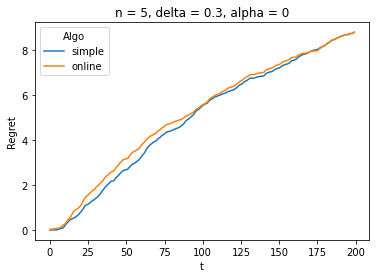

In [4]:
df = pd.DataFrame(regret_data)
p = sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None) #, ci="sd")
p.set_title(f"n = {n}, delta = {delta}, alpha = {alpha}")


In [5]:
np.array_equal(df[df['Algo'] == 'simple']['Regret'].to_numpy(), df[df['Algo'] == 'online']['Regret'].to_numpy())

False

In [6]:
np.where(df[df['Algo'] == 'simple']['Regret'].to_numpy() != df[df['Algo'] == 'online']['Regret'].to_numpy())

(array([   8,    9,  201,  202,  203,  204,  205,  206,  207,  208,  209,
         210,  211,  213,  214,  215,  422,  423,  424,  425,  426,  427,
         428,  429,  430,  431,  432,  433,  434,  435,  436,  437,  438,
         439,  440,  441,  442,  443,  444,  445,  446,  447,  448,  449,
         450,  451,  452,  453,  454,  455,  456,  457,  458,  459,  460,
         461,  462,  463,  464,  465,  466,  467,  468,  469,  470,  471,
         615,  616,  617,  618,  619,  620,  621,  622,  623,  624,  625,
         626,  627,  628,  629,  630,  631,  632,  633,  634,  635,  636,
         637,  638,  821,  822,  823,  824,  825,  826,  827,  828,  829,
         830,  831, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
        1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
        1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
        1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
        1054, 1055, 1056, 1057, 1058, 